# Descenso del gradiente
**Autor:** José A. Troyano &nbsp;&nbsp;&nbsp; **Revisor:**  Beatriz Pontes &nbsp;&nbsp;&nbsp;     &nbsp;&nbsp;&nbsp; **Última modificación:** 20/03/2023

-----------------------------------
## Contenido

1. <a href="#grafica"> La función <code>muestra_grafica</code>  </a> <br>
2. <a href="#descenso"> Búsqueda de mínimos mediante descenso del gradiente  </a> <br>
3. <a href="#hiperparametros"> El hiperparámetro <code>tasa_aprendizaje</code>  </a> <br>
4. <a href="#regresion"> Aplicación a la regresión lineal </a> <br>

------------------------------------------------------------------------------

En este _notebook_ veremos cómo implementar el método del descenso del gradiente para encontrar el mínimo de una función. Para, posteriormente, aplicarlo a la estimación de una recta de regresión a partir de una nube de puntos. 

Empezaremos por importar todos los elementos que usaremos a lo largo del notebook:

In [2]:
import math
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

## 1. La función <code>muestra_grafica</code> <a name="grafica"> </a>

Usaremos esta función para visualizar los distintos elementos que usaremos en el proceso de la búsqueda de mínimos mediante el descenso del gradiente:
- La función que pretendemos minimizar
- La trayectoria que se sigue en el proceso de búsqueda
- La nube de puntos cuando usamos como entrada un dataset, en lugar de una función

La siguiente imagen muestra un ejemplo que incluye los tres elementos anteriores:


<img src="./img/grafica.jpg" alt="Drawing" style="width:10cm;"/>



In [25]:
# EJERCICIO: definir la función 'muestra_grafica' que muestre los distintos elementos que usaremos en el descenso del gradiente
#   ENTRADA:
#      - funcion: la función que pretendemos minimizar
#      - busqueda: la trayectoria que se sigue en el proceso de búsqueda
#      - puntos: la nube de puntos cuando usamos como entrada un dataset, en lugar de una función
#      - rango_x: rango de valores posibles para el eje x, por defecto usaremos (-10,10)
#   Los tres elementos gráficos son opcionales, de manera que podremos usar la función para generar distintas configuraciones de gráficas
#
#   SALIDA:
#   - Gráfica con los elementos recibidos como parámetros. La función se trazará en azul, la búsqueda en rojo, y la nube de puntos en azul. 
#     El inicio de la búsqueda se marcará con un círculo, y el final con un aspa.



def muestra_grafica(funcion, busqueda, puntos, rango_x=(-10,10)):
    
    if funcion:
        xs = np.linspace(rango_x[0], rango_x[1], 400)
        ys = [funcion(x) for x in xs]
        sns.lineplot(x=xs, y=ys, color='black')
    
    if busqueda:
        xs, ys = zip(*busqueda)
        plt.plot(xs, ys, color='red')
        plt.scatter(xs[0], ys[0], marker='o', color='red', label='Inicio')
        plt.scatter(xs[-1], ys[-1], marker='x', color='red', label='Fin')
    
    if puntos:
        xs, ys = zip(*puntos)
        sns.scatterplot(x=xs, y=ys, color='blue', markers='o')

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Elementos en la gráfica')
    plt.grid(True)
    plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


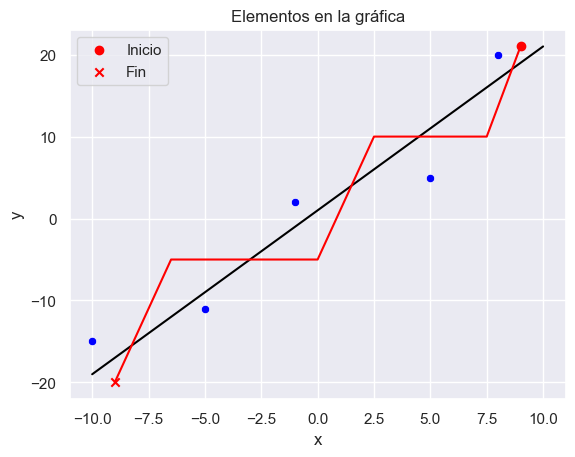

In [26]:
# TEST de la funcion 'muestra_grafica'        
muestra_grafica(funcion=lambda x:2*x+1, 
                busqueda=[(9,21), (7.5,10), (2.5,10), (0,-5), (-6.5,-5), (-9,-20)],
                puntos=[(-10,-15), (-5, -11), (-1,2), (5,5), (8,20)])

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


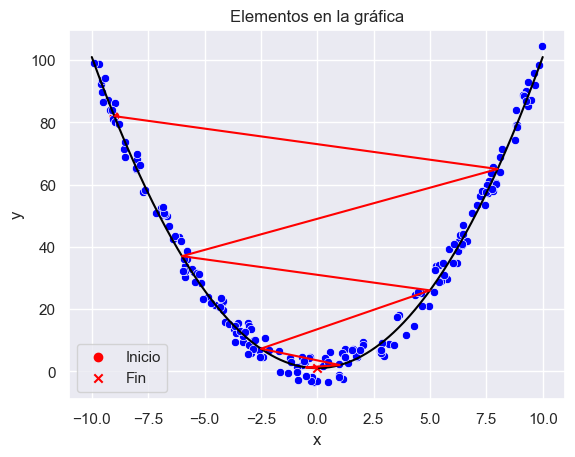

In [28]:
# EJERCICIO: usar la función muestra_grafica para visualizar los siguientes elementos:
#    - La función f(x) = x**2 + 1
#    - Una secuencia de búsqueda con los puntos de esa función correspondientes a siguientes valores de x [-9, 8, -6, 5, -2.5, 1, -0.5, 0]
#    - Una nube de 200 puntos con los siguientes valores para x e y:
#        - xs: 200 valores aleatorios entre -10 y 10
#        - ys: f(x) para cada valor de xs, con un ruido aleatorio entre -5 y 5

funcion = lambda x:x*x+1

xs =  [-9, 8, -6, 5, -2.5, 1, -0.5, 0]
ys = [funcion(x) for x in xs]
busqueda = zip(xs,ys)

xs = np.random.uniform(-10,10,200)
ys = [funcion(x)+np.random.uniform(-5,5) for x in xs]
puntos = zip(xs,ys)

muestra_grafica(funcion, busqueda, puntos)
#   

## 2. Búsqueda de mínimos mediante descenso del gradiente <a name="descenso"> </a>

En esta sección implementaremos la función <code>descenso_gradiente</code> que será la encargada de buscar, iterativamente, el mínimo de una función $f(x)$. Para ello, se buscará un valor $x_s$ en el que la derivada $f'(x_s)$ valga $0$, Siguiendo el siguiente proceso:
- Partir de una solución inicial $x_0$
- Mientras que el valor absoluto de $f'(x_i)$ sea mayor que un determinado umbral de precisión:
    - Calcular el valor de la derivada $f'(x_i)$ en el punto $x_i$
    - Modificar $x_i$, restándole una proporción (tasa de aprendizaje) de $f'(x_i)$

In [29]:
# EJERCICIO: definir la función 'descenso_gradiente' que calcule el mínimo de una función f(x)
#   ENTRADA:
#      - derivada: la derivada de la función que pretendemos minimizar
#      - inicio: valor inicial para la solución
#      - tasa_aprendizaje: porcentaje del gradiente que será restado en cada iteración (por defecto 0.1)
#      - precision: si el valor absoluto de f'(x) es menor o igual que el umbral de precisión, se finaliza la búsqueda (por defecto 1e-06)
#      - iteraciones: número máximo de iteraciones (por defecto 100)
#
#   SALIDA:
#      - Lista con todos los valores explorados para x, el último valor de la lista será la solución

def descenso_gradiente(derivada, inicio, tasa_aprendizaje=0.1, precision=1e-06, iteraciones=100):
    solucion = inicio
    soluciones = []
    for _ in range(iteraciones):
        soluciones.append(solucion)
        desplazamiento = -tasa_aprendizaje * derivada(solucion)
        if abs(desplazamiento)<=precision:
            break
        solucion += desplazamiento
    
    return soluciones

In [30]:
# EJERCICIO: 
#   - Usar la función descenso_gradiente para buscar el mínimo de la función f(x) = x**2+1, empezando por el valor inicial x=8
#   - Mostrar una gráfica con la función f(x) y la secuencia de posibles soluciones exploradas en la búsqueda

funcion = lambda x: x*x+1
derivada = lambda x:2*x

In [ ]:
# EJERCICIO: mostrar una gráfica con la función derivada f'(x) y la secuencia de posibles soluciones exploradas en la búsqueda, a
# parir de la misma configuración del ejercicio anterior.


## 3. El hiperparámetro <code>tasa_aprendizaje</code> <a name="hiperparametros"> </a>

En esta sección analizaremos el impacto del hiperparámetro <code>tasa_aprendizaje</code>, que regula la velocidad de cambio en la búsqueda del mínimo de una función. Como veremos en la próxima sección, cuando se realiza un ajuste se denominan _parámetros_ a los valores resultantes de la búsqueda de ese ajuste, mientras que los _hiperparámetros_ son los valores que nos permiten configurar la búsqueda. 

In [ ]:
# EJERCICIO: mostrar el resultado de aplicar el descenso del gradiente para calcular el mínimo de f(x) = x**2+1, 
# empezando por el punto 8, y con una tasa de aprendizaje de 0.0005


In [ ]:
# EJERCICIO: mostrar el resultado de aplicar el descenso del gradiente para calcular el mínimo de f(x) = x**2+1, 
# empezando por el punto 8, y con una tasa de aprendizaje de 0.8


In [ ]:
# EJERCICIO: mostrar el resultado de aplicar el descenso del gradiente para calcular el mínimo de f(x) = x**2+1, 
# empezando por el punto 2, y con una tasa de aprendizaje de 1.5.
# En este caso la búsqueda no va a converger, escoger un número de iteraciones y un rango_x que permita visualizar bien la gráfica.


In [ ]:
# EJERCICIO: crear dos funciones llamadas, respectivamente, funcion_p y derivada_p, para la función polinómica f(x) = x**4 - 10*x**2 - 4*x
# y su derivada.
# Trazar la curva de funcion_p, eligiendo un rango_x para que se observen bien los dos mínimos de la función.


In [ ]:
# EJERCICIO: mostrar el resultado de aplicar el descenso del gradiente para calcular el mínimo de funcion_p, 
# eligiendo un valor inicial que haga converger la búsqueda en el mínimo local


In [ ]:
# EJERCICIO: mostrar el resultado de aplicar el descenso del gradiente para calcular el mínimo de funcion_p, 
# eligiendo un valor inicial que haga converger la búsqueda en el mínimo global


In [ ]:
# EJERCICIO: mostrar una gráfica con la función derivada f'(x) y la secuencia de posibles soluciones exploradas en la búsqueda, a
# parir de la misma configuración del ejercicio anterior.


## 4. Aplicación a la regresión lineal <a name="regresion"> </a>

Ya tenemos todas las piezas para poder entrenar un regresor a partir de un dataset. Para ello aplicaremos la función <code>descenso_gradiente</code> para minimizar la _función de coste_ (también llamado _loss_). Este valor se calculará, en cada momento, mediante la suma de los cuadrados de los errores de la función estimada con respecto a los valores reales del dataset.

En esta ocasión aplicaremos el descenso del gradiente para estimar un regresor lineal, que se define mediante la función:

$$
f(x) = b_1x+b_0
$$

Siendo, en este caso, $b_0$ y $b_1$ los parámetros que estimaremos para ajustar el el modelo. 

La función de coste que minimizaremos será:

$$
C = \frac{1}{2n}\sum_i (y_i -f(x_i))^2 \\= \frac{1}{2n}\sum_i (y_i -b_1x_i - b_0))^2\\ 
  = \frac{1}{2n}\sum_i y^2_i + b^2_0 + b^2_1x^2_i  - 2b_0y_i  + 2b_0b_1x_i  - 2y_ib_1x_i
$$

Donde $(x_i, y_i)$ son todas las tuplas del dataset y $n$ es el número total de tuplas del dataset. En realidad la función de coste es $\frac{MSE}{2}$, siendo $MSE$ el error cuadrático medio. La división por $2$ se hace por conveniencia matemática, para que eliminar las multiplicaciones por $2$ que aparecerán al calcular la derivada de la función de coste. A partir de la definición de la función de coste, ya tenemos planteado nuestro problema de optimización, que consiste en encontrar los valores $b_0$ y $b_1$ que minimizan la función de coste $C(b_0, b_1)$. Al tratarse de una función de dos variables, tendremos que calcular sendas derivadas parciales para $b_0$ y $b_1$, que serán las funciones que tendremos que igualar a $0$:

$$
\frac{\partial C(b_0, b_1)}{\partial b_0} = \frac{\sum_i b_0 + b_1x_i - y_i}{n}\\
\frac{\partial C(b_0, b_1)}{\partial b_1} = \frac{\sum_i (b_0 + b_1x_i - y_i)x_i}{n}
$$

Estas funciones van a ser un poco más complejas que las que hemos usado hasta ahora en los ejemplos de descenso del gradiente. La primera diferencia es que, en lugar de estimar un valor numérico, en esta ocasión estimaremos un para de valores $b_0$ y $b_1$. Y la segunda diferencia es que, en lugar de usar una definición analítica, evaluaremos la función a partir de los ejemplos $(x_i, y_i)$ del dataset. En el siguiente ejercicio implementaremos la función <code>derivada_coste_rl</code> que tiene en cuenta estas dos modificaciones.

In [ ]:
# EJERCICIO: definir la función 'derivada_coste_rl' que calcule la derivada de la función de coste para la regresión lineal a partir de los valores de un dataset
#    ENTRADA:
#      - x: vector con todos los valores x_i del dataset
#      - y: vector con todos los valores y_i del dataset
#      - b: vector para la solución propuesta en cada momento
#    SALIDA:
#      - vector resultante de evaluar la derivada de la función de coste, a partir del dataset, en el punto (b_0, b_1) recibido como entrada
#    PISTA:
#      - La implementación será bastante sencilla gracias a las operaciones entre vectores de Numpy


In [ ]:
# TEST de la función 'derivada_coste_rl'
derivada_coste_rl([1.1, 1.8, 3.7], [0.9, 2.1, 3.5], [0,0])

Nuestra nueva función <code>descenso_gradiente_rl</code> requiere algunos cambios con respecto a <code>descenso_gradiente</code> para que podamos usarla para entrenar un regresor lineal. En concreto:
- Debe recibir como parámetros los vectores $x$ e $y$ que contienen los ejemplos del dataset de entrenamiento.
- En esta ocasión exploraremos un espacio $\mathbb R^2$ para encontrar los valores óptimos de $b_0$ y $b_1$, por lo que tendremos que adaptar la función para que maneje vectores en lugar de escalares.
- Para que converja adecuadamente, la tasa de aprendizaje debe ser bastante baja (usaremos $0.0005$ como valor por defecto) y el número de iteraciones bastante alto (usaremos $10^5$ como valor por defecto).

In [ ]:
# EJERCICIO: definir la función 'descenso_gradiente_rl' que:
#   - Maneje vectores en lugar de escalares
#   - Reciba como parámetros los vectores x e y que contienen los ejemplos del dataset de entrenamiento
#   ENTRADA:
#      - derivada: la derivada de la función que pretendemos minimizar
#      - x: vector con todos los valores x_i del dataset
#      - y: vector con todos los valores y_i del dataset
#      - inicio: vector inicial para la solución
#      - tasa_aprendizaje: porcentaje del gradiente que será restado en cada iteración (por defecto 0.0005)
#      - precision: si el valor absoluto de f'(x) es menor o igual que el umbral de precisión, se finaliza la búsqueda (por defecto 1e-06)
#      - iteraciones: número máximo de iteraciones (por defecto 100000)
#
#   SALIDA:
#      - Lista con todos los valores explorados para x, el último valor de la lista será la solución
#   PISTA:
#      - Gracias a Numpy, este cambio será fácil de implementar. Nos apoyaremos en las funciones np.abs() y np.all() para, respectivamente, calcular el 
#        valor absoluto de los componentes de un vector Numpy y para comprobar una condición para todos los componentes de un vector Numpy.


In [ ]:
# EJERCICIO: generar un dataset de puntos a patir de la función lineal f(x) = 3*x+2, y mostrar la gráfica correspondiente
#     El dataset estará compuesto por 200 puntos con los siguientes valores para x e y:
#        - xs: 200 valores aleatorios entre -10 y 10
#        - ys: 3*x+2 para cada valor de xs, con un ruido aleatorio entre -2 y 2


In [ ]:
# EJERCICIO: ejecutar el método del descenso del gradiente para el dataset generado en el ejercicio anterior:
#   - Empezando por (0,0) como solución inicial
#   - Mostrar con dos curvas la evolución de los valores que van tomando b_0 y b_1
#   - Mostrar en el título de la gráfica el número de iteraciones y el resultado final del ajuste


In [ ]:
# EJERCICIO: definir la función 'coste_rl' que calcule la función de coste para la regresión lineal a partir de los valores de un dataset
#    ENTRADA:
#      - x: vector con todos los valores x_i del dataset
#      - y: vector con todos los valores y_i del dataset
#      - b: vector para la solución propuesta en cada momento
#    SALIDA:
#      - valor de la función de coste, a partir del dataset, en el punto (b_0, b_1) recibido como entrada
#    PISTA:
#      - La implementación será bastante sencilla gracias a las operaciones entre vectores de Numpy


In [ ]:
# TEST de la función 'coste_rl'
print(coste_rl([1, 2, 3], [5, 8, 11], [2.1,2.9]))
print(coste_rl([1, 2, 3], [5, 8, 11], [10,6]))

In [ ]:
# EJERCICIO: ejecutar el código de ejemplo de matplotlib para la generación de diagramas de superficie 3D
#    Está disponible en: https://matplotlib.org/stable/gallery/mplot3d/surface3d.html


In [ ]:
# EJERCICIO: crear un diagrama de superfice que muestre una superficie 3D a partir la función de coste para regresión 
# lineal, siguiendo estos pasos:
#    - Crear una lista de 100 valores, distribuidos uniformemente entre 0 y 4, llamada rango_b0. 
#    - Crear una lista de 100 valores, distribuidos uniformemente entre 2.8 y 3.2, llamada rango_b1.
#    - Usar meshgrid para crear las matrices X e Y a partir de rango_b0 y rango_b1
#    - Crear la matriz Z con una fila para cada valor de rango_b0, y una columna para cada valor de rango_b1, que contenga en cada
#      celda el resultado de evaluar la función coste_rl para los correspondientes valores de b0 y b1
